In [1]:
import numpy as np
from pykal.block_dynamical_system import BlockDynamicalSystem as BlockDS
from numpy.typing import NDArray
import matplotlib.pyplot as plt

In [2]:
def lho_Q(x: NDArray) -> NDArray:
        return 0.01 * np.eye(2)

def lho_R(x: NDArray) -> NDArray:
        return 0.1 * np.eye(2)

def lho_f(x: NDArray, m: float = 1.0, c: float = 0.1, k: float = 1.0) -> NDArray:
    pos, vel = float(x[0]), float(x[1])
    dxdt = np.array([
        [vel],
        [-(c/m) * vel - (k/m) * pos]
    ], dtype=float).T
    return dxdt

def lho_h(x:NDArray) -> NDArray:
        return x

sys_lho_block = BlockDS(f = lho_f, h = lho_h, Q = lho_Q, R = lho_R,sys_type="cti") 


In [3]:
from pykal.compute import Simulation
x0 = np.asarray([2,0])
X_true,Y_true = Simulation.of_dynamical_system_block(block=sys_lho_block,x0=x0,t_span=(0,40),dt=0.1)

In [4]:
import pandas as pd
Xdf = pd.DataFrame(np.vstack(X_true), columns=["pos", "vel"])
Ydf = pd.DataFrame(np.vstack(X_true), columns=["meas_pos", "meas_vel"])

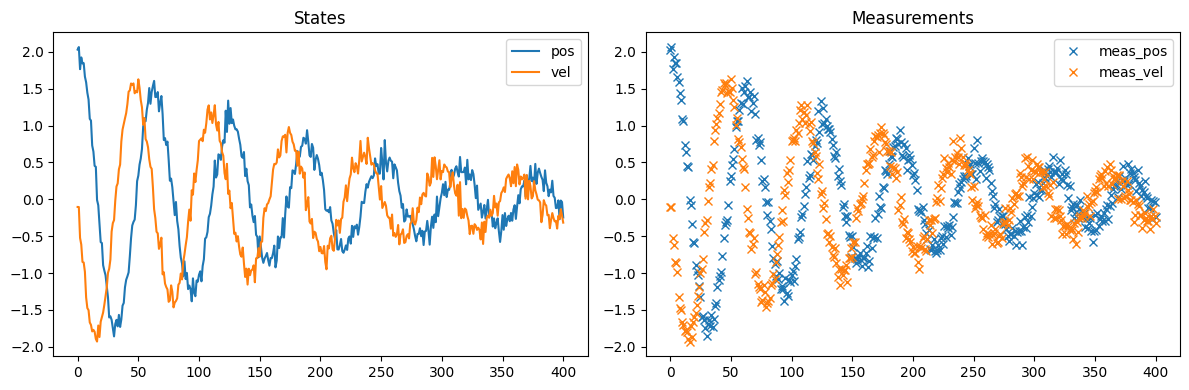

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

Xdf.plot(ax=axes[0], title="States")
Ydf.plot(ax=axes[1], title="Measurements", style='x')

plt.tight_layout()

In [6]:
dt = 0.1
t_span = np.arange(0,40,dt)

sys_lho_block.X = []
sys_lho_block.Y = []
xk = x0
rng = np.random.default_rng(42)
for tk in t_span:
    xk,yk = Simulation.of_dynamical_system_block(block=sys_lho_block,x0=xk,tk_in_sim=tk,dt=dt,rng=rng)
    sys_lho_block.X.append(xk)
    sys_lho_block.Y.append(yk)

In [7]:
Xdf = pd.DataFrame(np.vstack(sys_lho_block.X), columns=["pos", "vel"])
Ydf = pd.DataFrame(np.vstack(sys_lho_block.Y), columns=["meas_pos", "meas_vel"])

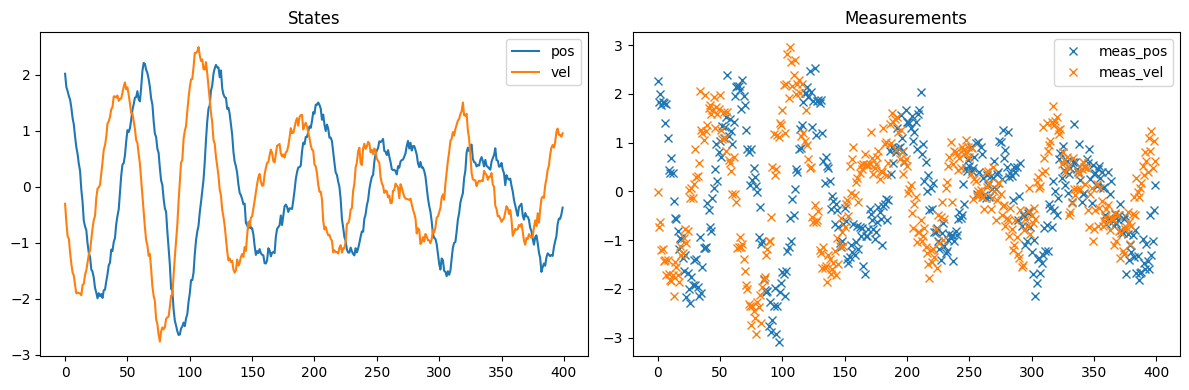

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

Xdf.plot(ax=axes[0], title="States")
Ydf.plot(ax=axes[1], title="Measurements", style='x')

plt.tight_layout()

In [6]:
from pykal_core.utils.control_system.safeio import SafeIO
import numpy as np
from numpy.typing import NDArray
from typing import Callable, Dict, Optional, Tuple

def ekf_f(
    xk: Tuple[NDArray, NDArray],  # [x̂ (n,1), P (n,n)]
    tk: float,
    *,
    yk: NDArray,
    dt: float,
    f: Callable,
    F: Callable,
    Q: Callable,
    h: Callable,
    H: Callable,
    R: Callable,
    f_sys_type: str,
    kwargs_at_time_tk: Optional[Dict] = None,
):

    if kwargs_at_time_tk is None:
        kwargs_at_time_tk = {}

    def ekf_predict(
        xk: Tuple[NDArray, NDArray],
        tk: float,
        dt: float,
        f: Callable,
        Q: Callable,
        F: Callable,
    ) -> Tuple[NDArray, NDArray]:
        xhat = xk[0]  # NDArray(n,1),
        Pk = xk[1]  # NDArray(n,n)

        Fk = SafeIO.smart_call(F, x=xhat, t=tk, kwargs_dict=kwargs_at_time_tk)
        Qk = SafeIO.smart_call(Q, x=xhat, t=tk, kwargs_dict=kwargs_at_time_tk)

        if f_sys_type in ("cti", "ctv"):
            xdot = SafeIO.smart_call(f, x=xhat, t=tk)
            x_pred = xhat + dt * xdot
            P_pred = Pk + dt * (Fk @ Pk + Pk @ Fk.T + Qk)

        elif f_sys_type in ("dti", "dtv"):
            x_pred = SafeIO.smart_call(f, x=xhat, t=tk)
            P_pred = Fk @ Pk @ Fk.T + Qk
        else:
            raise ValueError("f_sys_type must be one of ('cti','ctv','dti','dtv')")

        return (x_pred, P_pred)

    def ekf_update(
        xk: Tuple[NDArray, NDArray],
        yk: NDArray,
        tk: float,
        h: Callable,
        H: Callable,
        R: Callable,
    ) -> Tuple[NDArray, NDArray]:
        x_pred = xk[0]
        P_pred = xk[1]
        y_pred = SafeIO.smart_call(h, x=x_pred, t=tk, kwargs_dict=kwargs_at_time_tk)
        Hk = SafeIO.smart_call(H, x=x_pred, t=tk, kwargs_dict=kwargs_at_time_tk)

        m, n = y_pred.shape[0], x_pred.shape[0]
        # if Hk.shape != (m, n):
        #     raise ValueError(f"H(x) must be (m={m}, n={n}); got {Hk.shape}")

        Rk = SafeIO.smart_call(R, x=x_pred, t=tk, kwargs_dict=kwargs_at_time_tk)

        Sk = Hk @ P_pred @ Hk.T + Rk
        ridge = 1e-9 * np.eye(Sk.shape[0])
        try:
            Sk_inv = np.linalg.inv(Sk + ridge)
        except np.linalg.LinAlgError:
            Sk_inv = np.linalg.pinv(Sk + ridge)

        Kk = P_pred @ Hk.T @ Sk_inv
        innovation = yk - y_pred

        # State update
        x_upd = x_pred + innovation @ Kk.T

        # Covariance update (Joseph form – numerically safer)
        I = np.eye(x_pred.shape[0])
        P_upd = (I - Kk @ Hk) @ P_pred @ (I - Kk @ Hk).T + Kk @ Rk @ Kk.T

        # Symmetrize to fight FP drift
        P_upd = 0.5 * (P_upd + P_upd.T)

        return (x_upd, P_upd)

    # ---- run step ----
    xk_next = ekf_predict(xk, tk, dt, f, Q, F)
    xk_next = ekf_update(xk_next, yk, tk, h, H, R)
    return xk_next


def ekf_h(xk: Tuple[NDArray, NDArray]) -> NDArray:
    # Identity measurement: returns current state estimate
    return xk[0]



In [7]:
import numpy as np
from typing import Callable, Dict, Optional, Tuple
from numpy.typing import NDArray
from pykal_core.utils.control_system.safeio import SafeIO


def ekf_f(
    xk: Tuple[NDArray, NDArray],  # [x̂, P]
    tk: float,
    *,
    yk: NDArray,
    dt: float,
    f: Callable,
    F: Callable,
    Q: Callable,
    h: Callable,
    H: Callable,
    R: Callable,
    f_sys_type: str,
    kwargs_at_time_tk: Optional[Dict] = None,
) -> Tuple[NDArray, NDArray]:
    """
    Extended Kalman Filter step (predict + update) using column-vector convention internally.

    Shapes:
        x̂_k : (n, 1)
        P_k  : (n, n)
        y_k  : (m, 1)
        F,H  : (n,n), (m,n)
        Q,R  : (n,n), (m,m)
    """

    if kwargs_at_time_tk is None:
        kwargs_at_time_tk = {}

    # --- helpers ------------------------------------------------------------
    def as_col(v: NDArray) -> NDArray:
        v = np.asarray(v)
        if v.ndim == 1:
            return v.reshape(-1, 1)
        if v.ndim == 2:
            if v.shape[1] == 1:
                return v
            if v.shape[0] == 1:
                return v.T
        raise ValueError(f"Expected vector-like array; got shape {v.shape}")

    def same_orientation(v_col: NDArray, like: NDArray) -> NDArray:
        like = np.asarray(like)
        if like.ndim == 1:
            return v_col.reshape(-1)
        if like.ndim == 2 and like.shape[0] == 1:
            return v_col.T
        return v_col

    # --- normalize inputs ---------------------------------------------------
    xhat_in, Pk = xk
    xhat = as_col(xhat_in)    # (n,1)
    yk_col = as_col(yk)       # (m,1)

    # --- PREDICT ------------------------------------------------------------
    Fk = SafeIO.smart_call(F, x=xhat, t=tk, kwargs_dict=kwargs_at_time_tk)
    Qk = SafeIO.smart_call(Q, x=xhat, t=tk, kwargs_dict=kwargs_at_time_tk)

    if f_sys_type in ("cti", "ctv"):
        xdot = SafeIO.smart_call(f, x=xhat, t=tk, kwargs_dict=kwargs_at_time_tk)
        xdot = as_col(xdot)
        x_pred = xhat + dt * xdot
        P_pred = Pk + dt * (Fk @ Pk + Pk @ Fk.T + Qk)

    elif f_sys_type in ("dti", "dtv"):
        x_pred = SafeIO.smart_call(f, x=xhat, t=tk, kwargs_dict=kwargs_at_time_tk)
        x_pred = as_col(x_pred)
        P_pred = Fk @ Pk @ Fk.T + Qk

    else:
        raise ValueError("f_sys_type must be one of ('cti','ctv','dti','dtv')")

    # --- UPDATE -------------------------------------------------------------
    y_pred = SafeIO.smart_call(h, x=x_pred, t=tk, kwargs_dict=kwargs_at_time_tk)
    y_pred = as_col(y_pred)

    Hk = SafeIO.smart_call(H, x=x_pred, t=tk, kwargs_dict=kwargs_at_time_tk)
    Rk = SafeIO.smart_call(R, x=x_pred, t=tk, kwargs_dict=kwargs_at_time_tk)

    innovation = yk_col - y_pred                       # (m,1)
    Sk = Hk @ P_pred @ Hk.T + Rk                       # (m,m)
    ridge = 1e-9 * np.eye(Sk.shape[0])
    try:
        Sk_inv = np.linalg.inv(Sk + ridge)
    except np.linalg.LinAlgError:
        Sk_inv = np.linalg.pinv(Sk + ridge)

    Kk = P_pred @ Hk.T @ Sk_inv                        # (n,m)
    x_upd = x_pred + Kk @ innovation                   # (n,1)

    I = np.eye(P_pred.shape[0])
    P_upd = (I - Kk @ Hk) @ P_pred @ (I - Kk @ Hk).T + Kk @ Rk @ Kk.T
    P_upd = 0.5 * (P_upd + P_upd.T)                    # symmetrize

    # --- return in original orientation -------------------------------------
    x_out = same_orientation(x_upd, xhat_in)
    return (x_out, P_upd)


ekf_block = DSBlock(f = ekf_f, h = ekf_h, sys_type="dti") 

In [8]:
def lho_F(x: NDArray, m: float = 1.0, c: float = 0.1, k: float = 1.0) -> NDArray:
    """
    Jacobian of the damped harmonic oscillator dynamics wrt state.
    """
    return np.array([
        [0.0,       1.0],
        [-k/m, -c/m]
    ], dtype=float)

def lho_H(x: NDArray) -> NDArray:
    """
    Jacobian of measurement function wrt state.
    Identity, since h(x) = x.
    """
    n = x.shape[0]
    return np.eye(n, dtype=float)

In [9]:
def key_values_at_tk(
    input_dict: Dict, tk: float, t_linspace: NDArray
) -> Dict[str, NDArray]:
    """
    Extract parameter values from a time-dependent dictionary at time t.
    """

    def index_of_t(t: float, t_linspace: NDArray) -> int:
        """
        Map a continuous time value to the closest simulation index.
        """
        i = int(np.searchsorted(t_linspace, t, side="right") - 1)
        return (
            0 if i < 0 else (len(t_linspace) - 1 if i >= len(t_linspace) else i)
        )

    idx = index_of_t(tk, t_linspace)
    key_values_at_time_tk = {}
    for k, arr in input_dict.items():
        key_values_at_time_tk[k] = arr[idx]
    return key_values_at_time_tk

In [10]:
from pykal_core.utils.compute import Simulation
xk = np.asarray([2,0])
Pk = 0.1 * np.eye(2)
xk_ekf = [xk,Pk]
dt = 0.1
t_span = np.arange(0,40,dt) # time of simulation
ekf_block.X = []
ekf_block.Y = []
for tk in t_span:
    xk,yk = Simulation.of_dynamical_system_block(block=sys_lho_block,x0=xk,tk_in_sim=tk,dt=dt)
    xk_ekf,yk_ekf = Simulation.of_dynamical_system_block(block=ekf_block,x0=xk_ekf,tk_in_sim=tk,dt=dt,
                                                         kwarg_dict={
                                                             "yk":yk,
                                                             "f":lho_f,"F":lho_F,"h":lho_h,"H":lho_H,
                                                             "dt":dt,
                                                             "Q":lho_Q,"R":lho_R,"f_sys_type":"cti"})
    ekf_block.X.append(xk_ekf)
    ekf_block.Y.append(yk_ekf)

/tmp/ipykernel_71745/696187805.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos, vel = float(x[0]), float(x[1])


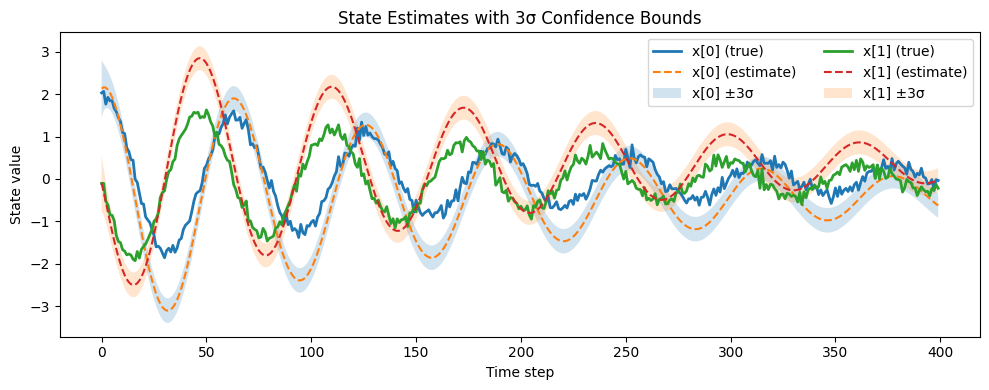

In [14]:
import numpy as np
import matplotlib.pyplot as plt

Xkf = ekf_block.X

# --- helpers ---
def _as_flat(v):
    a = np.asarray(v)
    return a.reshape(-1)  # (n,)

# --- materialize arrays ---
# True states: shape (T_true, n)
X_true = np.vstack([_as_flat(xk_true) for xk_true in X_true])
T_true, n_states = X_true.shape

# Estimates: x_est shape (T_est, n), P_est shape (T_est, n, n)
x_est = np.vstack([_as_flat(xhat) for (xhat, _) in Xkf])
P_est = np.stack([Pk for (_, Pk) in Xkf])
T_est = x_est.shape[0]

# --- align lengths ---
# Common cases:
#   - T_est == T_true
#   - T_est == T_true + 1  (e.g., you stored initial estimate at t=0 then T transitions)
if T_est == T_true + 1:
    # drop the final estimate to align with true trajectory
    x_est_plot = x_est[:-1]
    P_est_plot = P_est[:-1]
    T_plot = T_true
else:
    T_plot = min(T_true, T_est)
    x_est_plot = x_est[:T_plot]
    P_est_plot = P_est[:T_plot]
    X_true_plot = X_true[:T_plot]

t = np.arange(T_plot)  # x-axis; replace with your actual time vector if you have one

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 4))

for idx in range(n_states):
    true_i = X_true[:T_plot, idx]
    mean_i = x_est_plot[:, idx]
    std_i  = np.sqrt(P_est_plot[:, idx, idx])

    ax.plot(t, true_i, label=f"x[{idx}] (true)", linewidth=2)
    ax.plot(t, mean_i, '--', label=f"x[{idx}] (estimate)", markersize=5)
    ax.fill_between(t, mean_i - 3*std_i, mean_i + 3*std_i, alpha=0.2, label=f"x[{idx}] ±3σ")

ax.set_title("State Estimates with 3σ Confidence Bounds")
ax.set_xlabel("Time step")
ax.set_ylabel("State value")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()


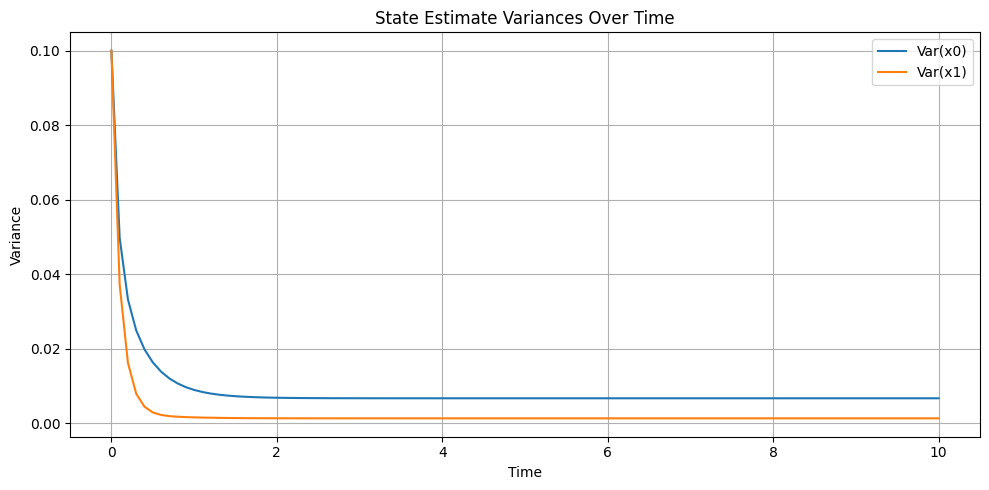

: 

: 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for idx, name in enumerate(sys.state_names):
    variances = np.array([Pestsr[t][idx, idx] for t in Xdf.index])
    ax.plot(Xdf.index, variances, label=f"Var({name})")

ax.set_title("State Estimate Variances Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

: 

: 